<a href="https://colab.research.google.com/github/kekekekekekekekekekekek/Movie-recommender/blob/main/AI_RIS2S1G3_CHEAHWOOIJUN_KEKZHEYANG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# 📦 Imports
# ==========================================
import streamlit as st
import pandas as pd
import numpy as np
import ast
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
# ==========================================
# ⚙️ Streamlit Page Config
# ==========================================
st.set_page_config(
    page_title="Movie Recommender System",
    page_icon="🎬",
    layout="wide",
    initial_sidebar_state="expanded"
)


In [ ]:
# ==========================================
# 📂 Dataset URLs
# ==========================================
MOVIES_URL = "https://drive.google.com/uc?export=download&id=1GOuUEu1-KgepbjTxIOkbAU8VNJ5lfEg3"
CREDITS_URL = "https://drive.google.com/uc?export=download&id=10iuK9C87fYLyDLJhqT3bpVv1A2IErmHR"
RATINGS_URL = "https://drive.google.com/uc?export=download&id=122XJoryYXvv3AUa6F_y1KiCcYdXQjEp4"


In [ ]:
# ==========================================
# 📂 Load Datasets
# ==========================================
@st.cache_data
def load_data_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return pd.read_csv(StringIO(response.text))

@st.cache_resource
def load_data():
    movies = load_data_from_url(MOVIES_URL)
    credits = load_data_from_url(CREDITS_URL)
    ratings = load_data_from_url(RATINGS_URL)

    # Filter movies
    movies = movies[movies['vote_count'] > 500]

    # Convert IDs
    movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
    credits['id'] = pd.to_numeric(credits['id'], errors='coerce')
    ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')
    movies = movies.dropna(subset=['id'])
    credits = credits.dropna(subset=['id'])
    ratings = ratings.dropna(subset=['movieId'])
    movies['id'] = movies['id'].astype(int)
    credits['id'] = credits['id'].astype(int)
    ratings['movieId'] = ratings['movieId'].astype(int)

    # Merge movies + credits
    movies = movies.merge(credits, on='id', how='inner')

    # Clean features
    movies['overview'] = movies['overview'].fillna('')
    movies['tagline'] = movies['tagline'].fillna('')
    movies['description'] = movies['overview'] + " " + movies['tagline']
    movies = movies[['id', 'title', 'description', 'genres', 'cast', 'crew']]

    # Parse
    def parse_genres(obj):
        try: return [i['name'] for i in ast.literal_eval(obj)]
        except: return []
    def parse_cast(obj):
        try: return [i['name'] for i in ast.literal_eval(obj)[:3]]
        except: return []
    def parse_crew(obj):
        try: return [i['name'] for i in ast.literal_eval(obj) if i['job'] == 'Director']
        except: return []

    movies['genres'] = movies['genres'].apply(parse_genres).apply(lambda x: " ".join(x))
    movies['cast'] = movies['cast'].apply(parse_cast).apply(lambda x: " ".join(x))
    movies['crew'] = movies['crew'].apply(parse_crew).apply(lambda x: " ".join(x))

    movies['final_features'] = (
        movies['description'] + ' ' +
        movies['genres'] + ' ' +
        movies['cast'] + ' ' +
        movies['crew']
    )

    return movies, ratings


In [ ]:
# ==========================================
# 🔧 Models: TF-IDF + Collaborative Data
# ==========================================
@st.cache_resource
def create_tfidf_model(movies):
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
    vectors = tfidf.fit_transform(movies['final_features'])
    return tfidf, vectors

@st.cache_resource
def prepare_collaborative_data(movies, ratings):
    movies_cf = movies[['id', 'title']].rename(columns={'id': 'movieId'})
    ratings = ratings.merge(movies_cf, on="movieId", how="inner")

    user_mapping = {1: "Bob", 2: "Alice", 3: "Charlie", 4: "Diana", 5: "Eve"}
    ratings['user_name'] = ratings['userId'].replace(user_mapping)

    user_item_matrix = ratings.pivot_table(
        index='user_name', columns='title', values='rating'
    ).fillna(0)

    user_sim = cosine_similarity(user_item_matrix)
    user_sim_df = pd.DataFrame(user_sim, index=user_item_matrix.index, columns=user_item_matrix.index)

    return ratings, user_item_matrix, user_sim_df


In [ ]:
# ==========================================
# 🔎 Recommendation Functions
# ==========================================
def content_based_recommend(movie_title, movies, vectors, top_n=10):
    if movie_title not in movies['title'].values:
        return "❌ Movie not found in dataset.", []
    idx = movies[movies['title'] == movie_title].index[0]
    cosine_scores = linear_kernel(vectors[idx], vectors).flatten()
    similar_indices = cosine_scores.argsort()[-(top_n+1):-1][::-1]
    recommendations = movies.iloc[similar_indices].title.tolist()
    scores = cosine_scores[similar_indices].tolist()
    return "Content-based recommendations", [(title, float(score)) for title, score in zip(recommendations, scores)]

def collaborative_recommend(user_name, user_item_matrix, user_sim_df, top_n=50):
    if user_name not in user_item_matrix.index:
        return {}
    sim_scores = user_sim_df[user_name].drop(user_name).sort_values(ascending=False)
    top_users = sim_scores.index[:5]
    neighbor_ratings = user_item_matrix.loc[top_users].mean(axis=0)
    watched = user_item_matrix.loc[user_name][user_item_matrix.loc[user_name] > 0].index
    neighbor_ratings = neighbor_ratings.drop(watched, errors='ignore')
    top_recs = neighbor_ratings.sort_values(ascending=False).head(top_n)
    return {title: score for title, score in top_recs.items()}

def hybrid_recommend(user_name, liked_movie, movies, vectors, user_item_matrix, user_sim_df, alpha=0.5, top_n=10):
    if not user_name or user_name.strip() == "" or user_name == "-":
        random_id = random.randint(6, 671)
        user_name = f"User_{random_id}"
    collab_scores = collaborative_recommend(user_name, user_item_matrix, user_sim_df, top_n=50)
    if liked_movie not in movies['title'].values:
        return user_name, [("❌ Movie not found", 0.0)]
    idx = movies.index[movies['title'] == liked_movie][0]
    cs = linear_kernel(vectors[idx], vectors).flatten()
    content_scores = {movies.iloc[i].title: float(cs[i]) for i in cs.argsort()[-51:-1]}
    all_titles = set(collab_scores.keys()) | set(content_scores.keys())
    hybrid_scores = {t: alpha*content_scores.get(t, 0.0) + (1-alpha)*collab_scores.get(t, 0.0) for t in all_titles}
    ranked = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return user_name, [(t, float(s)) for t, s in ranked]


In [ ]:
# ==========================================
# 📊 Evaluation Helpers
# ==========================================
def build_eval_helpers(movies, ratings, vectors):
    content_similarity = linear_kernel(vectors, vectors)
    ratings_aggregated = ratings.groupby(['userId', 'movieId'])['rating'].mean().reset_index()
    ratings_matrix = ratings_aggregated.pivot(index="userId", columns="movieId", values="rating").fillna(0)
    user_sim = cosine_similarity(ratings_matrix)
    user_sim_df = pd.DataFrame(user_sim, index=ratings_matrix.index, columns=ratings_matrix.index)

    def content_predict(user_id, movie_id):
        if movie_id not in movies['id'].values:
            return None
        idx = movies[movies['id'] == movie_id].index[0]
        sims = content_similarity[idx]
        user_ratings = ratings[ratings['userId'] == user_id]
        if user_ratings.empty:
            return None
        sim_scores = []
        for _, row in user_ratings.iterrows():
            if row['movieId'] in movies['id'].values:
                jdx = movies[movies['id'] == row['movieId']].index[0]
                sim_scores.append((row['rating'], sims[jdx]))
        if not sim_scores:
            return None
        weighted_sum = sum(r*s for r,s in sim_scores)
        sim_sum = sum(s for _,s in sim_scores)
        return weighted_sum/sim_sum if sim_sum != 0 else None

    def collab_predict(user_id, movie_id):
        if movie_id not in ratings_matrix.columns:
            return None
        if user_id not in user_sim_df.index:
            return None
        sims = user_sim_df[user_id].drop(user_id, errors='ignore')
        top_users = sims.sort_values(ascending=False).head(5).index
        if top_users.empty:
            return None
        top_ratings = ratings_matrix.loc[top_users, movie_id]
        weights = sims.loc[top_users]
        if weights.sum() == 0:
            return None
        return np.dot(top_ratings, weights)/weights.sum()

    def hybrid_predict(user_id, movie_id, alpha=0.5):
        cp = content_predict(user_id, movie_id)
        cf = collab_predict(user_id, movie_id)
        if cp is None and cf is None:
            return None
        if cp is None: return cf
        if cf is None: return cp
        return alpha*cp + (1-alpha)*cf

    return content_predict, collab_predict, hybrid_predict

def evaluate_model(predict_func, ratings_aggregated, n_samples=300):
    test = ratings_aggregated.sample(n_samples, random_state=42)
    preds, truths = [], []
    for _, row in test.iterrows():
        pred = predict_func(row['userId'], row['movieId'])
        if pred is not None:
            preds.append(pred)
            truths.append(row['rating'])
    if not preds:
        return None, None
    mse = mean_squared_error(truths, preds)
    rmse = np.sqrt(mse)
    return mse, rmse


📊 Evaluation Results:
          System       MSE      RMSE
0  Content-Based  0.278178  0.527426
1  Collaborative  5.172266  2.274262
2         Hybrid  1.493688  1.222165


/tmp/ipython-input-3011192621.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="System", y="RMSE", data=results_df, palette="viridis")


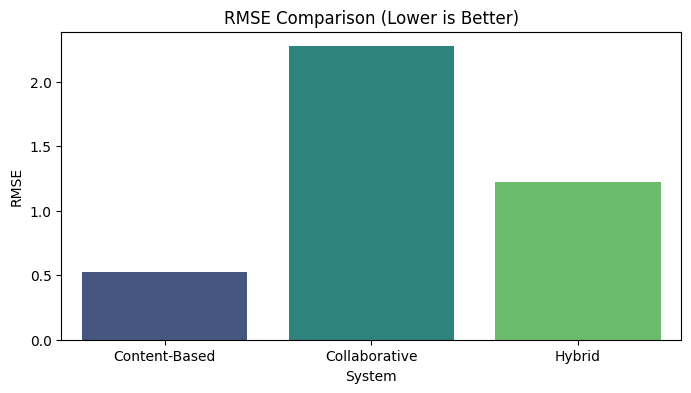

/tmp/ipython-input-3011192621.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="System", y="MSE", data=results_df, palette="magma")


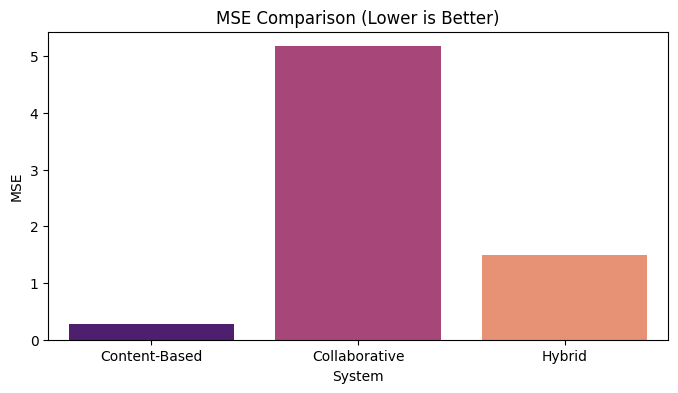

In [ ]:
# ==========================================
# 🚀 Main App
# ==========================================
def main():
    st.title("🎬 Movie Recommender System")

    with st.spinner("Loading data and building models..."):
        movies, ratings = load_data()
        tfidf, vectors = create_tfidf_model(movies)
        ratings, user_item_matrix, user_sim_df = prepare_collaborative_data(movies, ratings)

    # 🎭 Recommendation Section
    st.header("Movie Recommendations")
    rec_type = st.radio("Recommendation Type", ["Content-Based", "Hybrid"])
    user_choices = ["-", "Bob", "Alice", "Charlie", "Diana", "Eve"]
    if rec_type == "Hybrid":
        user_choice = st.selectbox("Select Movie Critic", user_choices)
    else:
        user_choice = "-"
    movie_choices = sorted(movies['title'].unique().tolist())
    movie_title = st.selectbox("Select a Movie", movie_choices)
    num_recs = st.slider("Number of Recommendations", 1, 20, 10)

    if st.button("Get Recommendations"):
        if rec_type == "Content-Based":
            method_name, recs = content_based_recommend(movie_title, movies, vectors, top_n=num_recs)
            resolved_user = "Content-Based Filtering"
        else:
            user_input = "" if (user_choice is None or user_choice == "-") else user_choice
            resolved_user, recs = hybrid_recommend(user_input, movie_title, movies, vectors, user_item_matrix, user_sim_df, alpha=0.5, top_n=num_recs)
            method_name = "Hybrid recommendations"

        if isinstance(recs, str) or len(recs) == 0:
            st.error(recs if isinstance(recs, str) else "❌ No recommendations found.")
        else:
            scores = [s for _, s in recs]
            max_score = max(scores) if scores else 1.0
            rows = []
            for i, (title, score) in enumerate(recs, start=1):
                norm_percentage = (score / max_score) * 100 if max_score > 0 else 0
                rows.append([f"{i}. {title}", f"{norm_percentage:.1f}%"])
            user_display = resolved_user if rec_type == "Hybrid" else "Content-Based Filtering"
            st.subheader(f"🎭 {method_name} for {user_display} (based on {movie_title}):")
            rec_df = pd.DataFrame(rows, columns=["Movie", "Score"])
            st.table(rec_df)

    # 📊 Evaluation Section
    st.header("📊 Model Evaluation")
    content_predict, collab_predict, hybrid_predict = build_eval_helpers(movies, ratings, vectors)
    ratings_aggregated = ratings.groupby(['userId', 'movieId'])['rating'].mean().reset_index()

    mse_content, rmse_content = evaluate_model(content_predict, ratings_aggregated)
    mse_collab, rmse_collab = evaluate_model(collab_predict, ratings_aggregated)
    mse_hybrid, rmse_hybrid = evaluate_model(hybrid_predict, ratings_aggregated)

    results_df = pd.DataFrame({
        "System": ["Content-Based", "Collaborative", "Hybrid"],
        "MSE": [mse_content, mse_collab, mse_hybrid],
        "RMSE": [rmse_content, rmse_collab, rmse_hybrid]
    })
    st.write("### Evaluation Results")
    st.dataframe(results_df)

    # RMSE Plot
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(x="System", y="RMSE", data=results_df, palette="viridis", ax=ax)
    ax.set_title("RMSE Comparison (Lower is Better)")
    st.pyplot(fig)

    # MSE Plot
    fig, ax = plt.subplots(figsize=(6,4))
    sns.barplot(x="System", y="MSE", data=results_df, palette="magma", ax=ax)
    ax.set_title("MSE Comparison (Lower is Better)")
    st.pyplot(fig)

if __name__ == "__main__":
    main()


In [ ]:
# Cell 8: Gradio UI setup with toggle
# Gradio UI setup
user_choices = ["-", "Bob", "Alice", "Charlie", "Diana", "Eve"]
movie_choices = sorted(movies['title'].unique().tolist())

def get_recommendations(recommendation_type, user_choice, movie_title, num_recs):
    if not movie_title or movie_title.strip() == "":
        return "❌ Please select a movie first."

    if recommendation_type == "Content-Based":
        method_name, recs = content_based_recommend(movie_title, top_n=num_recs)
        resolved_user = "Content-Based Filtering"
    else:  # Hybrid
        user_input = "" if (user_choice is None or user_choice == "-") else user_choice
        resolved_user, recs = hybrid_recommend(user_input, movie_title, alpha=0.5, top_n=num_recs)
        method_name = "Hybrid recommendations"

    # Check if we got an error message
    if isinstance(recs, str) or len(recs) == 0:
        return recs if isinstance(recs, str) else "❌ No recommendations found."

    # Extract scores for normalization
    scores = [s for _, s in recs]
    max_score = max(scores) if scores else 1.0

    # Normalize scores so the top one is 100%
    rows = []
    for i, (title, score) in enumerate(recs, start=1):
        norm_percentage = (score / max_score) * 100 if max_score > 0 else 0
        rows.append([f"{i}. {title}", f"{norm_percentage:.1f}%"])

    # Build HTML table
    rows_html = "".join(
        f"<tr><td style='padding:6px 12px;border-bottom:1px solid #eee;'>{movie}</td>"
        f"<td style='padding:6px 12px;text-align:center;border-bottom:1px solid #eee;'>{score}</td></tr>"
        for movie, score in rows
    )

    user_display = resolved_user if recommendation_type == "Hybrid" else "Content-Based Filtering"

    table_html = (
        f"<div style='font-weight:600;margin:6px 0;'>🎭 {method_name} for {user_display} (based on {movie_title}):</div>"
        "<table style='width:100%;border-collapse:collapse;font-size:15px;'>"
        "<thead><tr><th style='text-align:left;padding:6px 12px;border-bottom:2px solid #ccc;'>Movie</th>"
        "<th style='text-align:center;padding:6px 12px;border-bottom:2px solid #ccc;'>Score</th></tr></thead>"
        f"<tbody>{rows_html}</tbody></table>"
    )

    return table_html

with gr.Blocks() as demo:
    gr.Markdown("## 🎬 Movie Recommender System")

    # Toggle for recommendation type
    recommendation_type = gr.Radio(
        choices=["Content-Based", "Hybrid"],
        value="Content-Based",
        label="Recommendation Type"
    )

    with gr.Row():
        user_dropdown = gr.Dropdown(
            user_choices,
            label="Select Movie Critic (for Hybrid only)",
            value="-",
            interactive=True
        )
        movie_dropdown = gr.Dropdown(
            movie_choices,
            label="Select a Movie",
            interactive=True
        )

    num_recs = gr.Slider(
        1, 20, value=10, step=1,
        label="Number of Recommendations"
    )

    output_html = gr.HTML()

    # Show/hide user dropdown based on recommendation type
    def toggle_user_dropdown(rec_type):
        return gr.Dropdown(visible=(rec_type == "Hybrid"))

    recommendation_type.change(
        fn=toggle_user_dropdown,
        inputs=recommendation_type,
        outputs=user_dropdown
    )

    gr.Button("✨ Get Recommendations").click(
        get_recommendations,
        [recommendation_type, user_dropdown, movie_dropdown, num_recs],
        output_html
    )

# Launch the interface
demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b2d1c786515ef52d3a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
